In [1]:
from pipeline.gui import tabs

/opt/conda/envs/cp_dock/lib/python3.8/site-packages/pyqtgraph/colors/palette.py:1: RuntimeWarning: PyQtGraph supports Qt version >= 5.15, but 5.12.1 detected.
  from ..Qt import QtGui


In [2]:
tabs.start_gui()

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'


GUI_INFO: selected model twoFishMacrophage, loading now
GUI_INFO: diameter set to  11.31 (but can be changed)


SystemExit: 0

In [13]:
from tifffile import imread, imwrite
from matplotlib.pyplot import imshow
import json

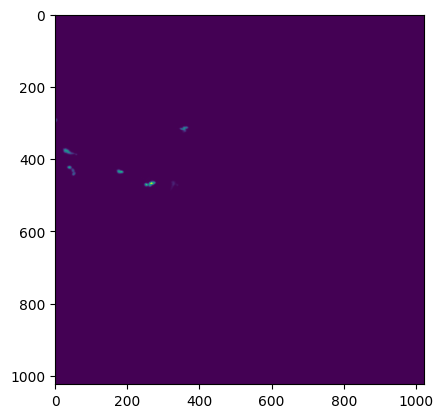

In [7]:
img = imread('/home/Fabian/ImageData/mfap4-mpx_isohypo_2h_WT-MaxIP_s1/Images/GFP_s01_f0001_z0001.tif')
imshow(img)

In [52]:
save_dir='/home/Fabian/ImageData/Test/GFP_s01_f0001_z0001.tif'
save2 = '/home/Fabian/ImageData/Test/GFP_s01_f0002_z0001.tif'

In [43]:
resolution = (1.5399, 1.5399)

In [58]:
ijinfo = {"finterval": 180, 'unit': 'um', 'Title': 'New lovely mask'}

In [59]:
imwrite(save_dir, img, imagej=True, resolution=resolution, metadata=ijinfo)

In [56]:
from tifffile import TiffFile
with TiffFile(save2) as tif:
    imagej_meta = tif.imagej_metadata
    # imagej_meta['axes'] = tif.series[0].axes
    for page in tif.pages: # Add additional meta
        for tag in page.tags:
            # if tag.name in ['ImageWidth','ImageLength',]:
            #     imagej_meta[tag.name] = tag.value
            # if tag.name in ['XResolution','YResolution']:
            #     imagej_meta[tag.name] = tag.value[0]/tag.value[1]
            print(tag)
    

TiffTag 256 ImageWidth @10 LONG @18 = 1024
TiffTag 257 ImageLength @22 LONG @30 = 1024
TiffTag 258 BitsPerSample @34 SHORT @42 = 16
TiffTag 259 Compression @46 SHORT @54 = NONE
TiffTag 262 PhotometricInterpretation @58 SHORT @66 = MINISBLACK
TiffTag 270 ImageDescription @70 ASCII[76] @206 = ImageJ=1.11a images=1 hyperst
TiffTag 273 StripOffsets @82 LONG @90 = (432,)
TiffTag 277 SamplesPerPixel @94 SHORT @102 = 1
TiffTag 278 RowsPerStrip @106 LONG @114 = 1024
TiffTag 279 StripByteCounts @118 LONG @126 = (2097152,)
TiffTag 282 XResolution @130 RATIONAL @346 = (4294967295, 2789120914)
TiffTag 283 YResolution @142 RATIONAL @354 = (4294967295, 2789120914)
TiffTag 296 ResolutionUnit @154 SHORT @162 = NONE
TiffTag 305 Software @166 ASCII[12] @362 = tifffile.py
TiffTag 50838 IJMetadataByteCounts @178 LONG[2] @374 = (12, 30)
TiffTag 50839 IJMetadata @190 BYTE[42] @382 = {'Labels': 'New lovely mask'}


In [10]:
from __future__ import annotations
import os
from typing import Iterable
import numpy as np
from tifffile import imread

def load_stack(img_list: list[os.PathLike], channel_list: str | Iterable[str], frame_range: int | Iterable[int], return_2D: bool=False)-> np.ndarray:
    # Convert to list if string or int
    if isinstance(channel_list, str):
        channel_list = [channel_list]
    
    if isinstance(frame_range, int):
        frame_range = [frame_range]
    
    # Load/Reload stack. Expected shape of images tzxyc
    exp_list = []
    for chan in channel_list:
        chan_list = []
        for frame in frame_range:
            f_lst = []
            for img in img_list:
                # To be able to load either _f3digit.tif or _f4digit.tif
                ndigit = len(img.split(os.sep)[-1].split('_')[2][1:])
                if chan in img and img.__contains__(f'_f%0{ndigit}d'%(frame+1)):
                    f_lst.append(imread(img))
            chan_list.append(f_lst)
        exp_list.append(chan_list)
    
    if len(channel_list)==1:
        stack = np.squeeze(np.stack(exp_list))
    else:
        stack = np.moveaxis(np.squeeze(np.stack(exp_list)), [0], [-1])

    # If stack is already 2D or want to load 3D
    if not return_2D or len(f_lst)==1:
        return stack
    
    # if stack is time series, then z is axis 1
    if len(frame_range)>1:
        return np.amax(stack, axis=1)
    # if not then z is axis 0
    else:
        return np.amax(stack, axis=0)

path = '/media/ben/Analysis/Python/Docker_mount/Test_images/nd2/Run2/c2z25t23v1_nd2_s1/Images'
img_list = [os.path.join(path,img) for img in sorted(os.listdir(path))]
stack = load_stack(img_list, 'GFP', range(5), False)
stack.shape

(5, 25, 512, 512)

In [15]:

sort_frame = {frame: [path for path in sorted(os.listdir(path)) if f"_f{frame+1:04d}" in path] for frame in range(23)}
sort_frame

{0: ['GFP_s01_f0001_z0001.tif',
  'GFP_s01_f0001_z0002.tif',
  'GFP_s01_f0001_z0003.tif',
  'GFP_s01_f0001_z0004.tif',
  'GFP_s01_f0001_z0005.tif',
  'GFP_s01_f0001_z0006.tif',
  'GFP_s01_f0001_z0007.tif',
  'GFP_s01_f0001_z0008.tif',
  'GFP_s01_f0001_z0009.tif',
  'GFP_s01_f0001_z0010.tif',
  'GFP_s01_f0001_z0011.tif',
  'GFP_s01_f0001_z0012.tif',
  'GFP_s01_f0001_z0013.tif',
  'GFP_s01_f0001_z0014.tif',
  'GFP_s01_f0001_z0015.tif',
  'GFP_s01_f0001_z0016.tif',
  'GFP_s01_f0001_z0017.tif',
  'GFP_s01_f0001_z0018.tif',
  'GFP_s01_f0001_z0019.tif',
  'GFP_s01_f0001_z0020.tif',
  'GFP_s01_f0001_z0021.tif',
  'GFP_s01_f0001_z0022.tif',
  'GFP_s01_f0001_z0023.tif',
  'GFP_s01_f0001_z0024.tif',
  'GFP_s01_f0001_z0025.tif',
  'RFP_s01_f0001_z0001.tif',
  'RFP_s01_f0001_z0002.tif',
  'RFP_s01_f0001_z0003.tif',
  'RFP_s01_f0001_z0004.tif',
  'RFP_s01_f0001_z0005.tif',
  'RFP_s01_f0001_z0006.tif',
  'RFP_s01_f0001_z0007.tif',
  'RFP_s01_f0001_z0008.tif',
  'RFP_s01_f0001_z0009.tif',
  'RFP_s01_

In [5]:
lst = ['GFP_s01_f0002_z0022.tif',
  'GFP_s01_f0002_z0023.tif',
  'GFP_s01_f0002_z0024.tif',
  'GFP_s01_f0002_z0025.tif',
  'RFP_s01_f0002_z0001.tif',
  'RFP_s01_f0002_z0002.tif',
  'RFP_s01_f0002_z0003.tif',
  'RFP_s01_f0002_z0004.tif',
  'RFP_s01_f0002_z0005.tif',
  'RFP_s01_f0002_z0006.tif',
  'RFP_s01_f0002_z0007.tif',]
order = ['RFP', 'GFP']
def custom_sort_key(name):
    try:
        return order.index(name)
    except ValueError:
        return len(order)
sorted(lst, key=order.index['RFP'])

TypeError: 'builtin_function_or_method' object is not subscriptable

In [1]:
from nd2 import ND2File

path = '/home/Test_images/nd2/Run3/c3z1t1v3.nd2'
with ND2File(path) as obj:
    nd2meta = {**obj.sizes}
    nd2meta['um_per_pixel'] = obj.metadata.channels[0].volume.axesCalibration[:2]
    nd2meta['T'] = 1 if 'T' not in nd2meta else nd2meta['T']
    if nd2meta['T']>1:
        nd2meta['interval_sec'] = obj.experiment[0].parameters.periodMs/1000
    else:
        nd2meta['interval_sec'] = None
    obj.close()
    
nd2meta['T'] = 1 if 'T' not in nd2meta else nd2meta['T']
nd2meta['C'] = 1 if 'C' not in nd2meta else nd2meta['C']
nd2meta['Z'] = 1 if 'Z' not in nd2meta else nd2meta['Z']
nd2meta['P'] = 1 if 'P' not in nd2meta else nd2meta['P']

original_keys = ['C', 'Z', 'T', 'P', 'X', 'Y']
new_keys = ['full_n_channels', 'n_slices', 'n_frames', 'n_series', 'img_width', 'img_length']

for i, key in enumerate(original_keys):
    nd2meta[new_keys[i]] = nd2meta.pop(key)

nd2meta['axes'] = ''
nd2meta['file_type'] = '.nd2'

nd2meta

{'um_per_pixel': (0.325, 0.325),
 'interval_sec': None,
 'full_n_channels': 3,
 'n_slices': 1,
 'n_frames': 1,
 'n_series': 3,
 'img_width': 1024,
 'img_length': 1024,
 'axes': '',
 'file_type': '.nd2'}

In [2]:
with ND2File(path) as obj:
    arr = obj.asarray()
    obj.close()
arr.shape

(3, 3, 1024, 1024)

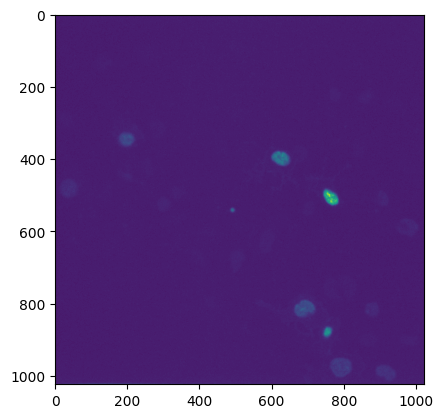

In [17]:
from matplotlib.pyplot import imshow
imshow(arr[(0,2)])

In [8]:
from __future__ import annotations
from tifffile import TiffFile

img_path = '/home/Test_images/tiff/Run3/c3z1t1v3s1.tif'

def calculate_um_per_pixel(meta_dict: dict) -> tuple[float,float]:
    """Calculate the um per pixel from the metadata of a tiff file. Output axes = (x,y)"""
    x_um_per_pix = round(1/meta_dict['XResolution'],ndigits=3)
    y_um_per_pix = round(1/meta_dict['YResolution'],ndigits=3)
    return x_um_per_pix,y_um_per_pix


tiff_meta = {}
# Open tif and read meta
with TiffFile(img_path) as tif:
    imagej_meta = tif.imagej_metadata
    imagej_meta['axes'] = tif.series[0].axes
    for page in tif.pages: # Add additional meta
        for tag in page.tags:
            if tag.name in ['ImageWidth','ImageLength',]:
                imagej_meta[tag.name] = tag.value
            if tag.name in ['XResolution','YResolution']:
                imagej_meta[tag.name] = tag.value[0]/tag.value[1]

if 'frames' not in imagej_meta: imagej_meta['frames'] = 1

if 'channels' not in imagej_meta: imagej_meta['channels'] = 1

if 'slices' not in imagej_meta: imagej_meta['slices'] = 1

if 'finterval' not in imagej_meta: 
    imagej_meta['finterval'] = None
else:
    imagej_meta['finterval'] = int(imagej_meta['finterval'])

original_keys = ['ImageWidth','ImageLength','frames','channels','slices','axes','finterval']
new_keys = ['img_width','img_length','n_frames','full_n_channels','n_slices','axes','interval_sec']

for i, key in enumerate(original_keys):
    tiff_meta[new_keys[i]] = imagej_meta[key]


tiff_meta['n_series'] = 1
tiff_meta['um_per_pixel'] = calculate_um_per_pixel(imagej_meta)

tiff_meta['file_type'] = '.tif'
tiff_meta

{'img_width': 1024,
 'img_length': 1024,
 'n_frames': 1,
 'full_n_channels': 3,
 'n_slices': 1,
 'axes': 'CYX',
 'interval_sec': None,
 'n_series': 1,
 'um_per_pixel': (0.325, 0.325),
 'file_type': '.tif'}

In [11]:
s = 'TZCYX'
s.replace('T','')

'ZCYX'